In [14]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard

In [15]:
path =r'../data/datasets_by_year/'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    df = pd.read_csv(filename).drop(columns=["Unnamed: 0", "individual-local-identifier"])
    if df.shape > (40,):
        dfs.append(df)

In [16]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    return train_df, val_df,test_df

In [17]:
split_data_result = [split_data(df) for df in dfs]

In [18]:
def data_windowing(train_df,val_df,test_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
        
    window_val = tf.keras.utils.timeseries_dataset_from_array(
    val_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    return window_train, window_test, window_val

In [6]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2]
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return X,y


In [29]:
type(train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [19]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=2)
])

In [20]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

In [21]:
for i, (train_df,val_df,test_df) in enumerate(split_data_result):
    
    print(i,len(split_data_result))
    
    window_train,window_val,window_test = data_windowing(train_df,val_df,test_df)
    train = window_train.map(data_map)
    test = window_test.map(data_map)
    val = window_val.map(data_map)
    
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=2,
                                                    mode='min')
    
    tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)
    
    history = lstm_model.fit(train, epochs=20,
                             validation_data=val,
                             callbacks=[early_stopping, tensorboard_callback])
    
hist_df = pd.DataFrame(history.history)


0 82
Epoch 1/20


2021-10-20 12:26:57.054458: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:26:57.054569: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:26:57.055011: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 244ms/step - loss: 7427.0259 - mean_absolute_error: 74.4905


2021-10-20 12:26:58.427289: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:26:58.427330: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:26:58.489894: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:26:58.497272: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:26:58.522927: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_26_58

2021-10-20 12:26:58.537724: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_26_58/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:26:58.552510: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_26_58

2021-10-20 12:26:58.

Epoch 2/20
2/2 [==============================] - 0s 58ms/step - loss: 7409.9092 - mean_absolute_error: 74.3804
Epoch 3/20
2/2 [==============================] - 0s 59ms/step - loss: 7394.8618 - mean_absolute_error: 74.2863
Epoch 4/20
2/2 [==============================] - 0s 51ms/step - loss: 7382.7021 - mean_absolute_error: 74.2134
Epoch 5/20
2/2 [==============================] - 0s 52ms/step - loss: 7373.7075 - mean_absolute_error: 74.1639
Epoch 6/20
2/2 [==============================] - 0s 55ms/step - loss: 7367.5796 - mean_absolute_error: 74.1343
Epoch 7/20
2/2 [==============================] - 0s 64ms/step - loss: 7362.5967 - mean_absolute_error: 74.1107
Epoch 8/20
2/2 [==============================] - 0s 55ms/step - loss: 7357.8794 - mean_absolute_error: 74.0865
Epoch 9/20
2/2 [==============================] - 0s 52ms/step - loss: 7353.4019 - mean_absolute_error: 74.0615
Epoch 10/20
2/2 [==============================] - 0s 52ms/step - loss: 7349.3945 - mean_absolute_error:

2021-10-20 12:27:00.649434: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:00.649495: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:00.649532: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:00.836160: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:00.836199: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 114ms/step - loss: 7630.0264 - mean_absolute_error: 76.2028
Epoch 3/20
1/1 [==============================] - 0s 52ms/step - loss: 7622.1743 - mean_absolute_error: 76.1729


2021-10-20 12:27:00.851862: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:00.854792: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:00.872028: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_00

2021-10-20 12:27:00.879646: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_00/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:00.887322: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_00

2021-10-20 12:27:00.890579: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_00/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 7615.4648 - mean_absolute_error: 76.1432
Epoch 5/20
1/1 [==============================] - 0s 53ms/step - loss: 7609.5352 - mean_absolute_error: 76.1150
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 7603.9868 - mean_absolute_error: 76.0876
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 7598.5376 - mean_absolute_error: 76.0595
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 7593.0889 - mean_absolute_error: 76.0302
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 7587.6924 - mean_absolute_error: 76.0001
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 7582.4639 - mean_absolute_error: 75.9695
Epoch 11/20
1/1 [==============================] - 0s 54ms/step - loss: 7577.4736 - mean_absolute_error: 75.9383
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 7572.6523 - mean_absolute_erro

2021-10-20 12:27:02.536982: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:02.537029: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:02.537063: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:02.721761: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:02.721802: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 118ms/step - loss: 7646.3564 - mean_absolute_error: 76.0103
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 7643.6313 - mean_absolute_error: 75.9843


2021-10-20 12:27:02.738818: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:02.742218: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:02.761453: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_02

2021-10-20 12:27:02.770370: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_02/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:02.778166: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_02

2021-10-20 12:27:02.780959: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_02/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 54ms/step - loss: 7640.8218 - mean_absolute_error: 75.9565
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 7637.9736 - mean_absolute_error: 75.9291
Epoch 6/20
1/1 [==============================] - 0s 51ms/step - loss: 7635.1226 - mean_absolute_error: 75.9040
Epoch 7/20
1/1 [==============================] - 0s 54ms/step - loss: 7632.2139 - mean_absolute_error: 75.8804
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 7629.1787 - mean_absolute_error: 75.8575
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 7625.9736 - mean_absolute_error: 75.8351
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 7622.6289 - mean_absolute_error: 75.8138
Epoch 11/20
1/1 [==============================] - 0s 55ms/step - loss: 7619.2876 - mean_absolute_error: 75.7942
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 7616.1719 - mean_absolute_erro

2021-10-20 12:27:04.431338: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:04.431379: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:04.431411: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:04.612496: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:04.612537: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:04.629307: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:04.632201: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 107ms/step - loss: 6979.3740 - mean_absolute_error: 71.7858
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 6977.0107 - mean_absolute_error: 71.7693
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 6974.6616 - mean_absolute_error: 71.7530

2021-10-20 12:27:04.648134: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_04

2021-10-20 12:27:04.655492: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_04/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:04.661707: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_04

2021-10-20 12:27:04.664045: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_04/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:27:04.681812: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_04
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_20_12_27_04/DE

1/1 [==============================] - 0s 52ms/step - loss: 6974.6616 - mean_absolute_error: 71.7530
Epoch 5/20
1/1 [==============================] - 0s 53ms/step - loss: 6972.3257 - mean_absolute_error: 71.7368
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 6970.0039 - mean_absolute_error: 71.7207
Epoch 7/20
1/1 [==============================] - 0s 54ms/step - loss: 6967.6924 - mean_absolute_error: 71.7047
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 6965.3936 - mean_absolute_error: 71.6888
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 6963.1069 - mean_absolute_error: 71.6730
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 6960.8281 - mean_absolute_error: 71.6572
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 6958.5610 - mean_absolute_error: 71.6415
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 6956.3018 - mean_absolute_error: 71.6259


2021-10-20 12:27:06.306683: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:06.306737: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:06.306770: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:06.412828: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:06.412871: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:06.427470: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:06.429781: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:06.445071: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_06

2021-10-20 12:27:06.451048: I tensorflow/core/profil

3/3 [==============================] - 0s 82ms/step - loss: 6896.3804 - mean_absolute_error: 70.8833
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 6889.7681 - mean_absolute_error: 70.8374
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 6882.8403 - mean_absolute_error: 70.7897
Epoch 4/20
3/3 [==============================] - 0s 29ms/step - loss: 6874.9731 - mean_absolute_error: 70.7358
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 6864.7056 - mean_absolute_error: 70.6662
Epoch 6/20
3/3 [==============================] - 0s 30ms/step - loss: 6850.6948 - mean_absolute_error: 70.5721
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 6834.0576 - mean_absolute_error: 70.4602
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 6818.2905 - mean_absolute_error: 70.3546
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 6807.8403 - mean_absolute_error: 70.2838
Epo

2021-10-20 12:27:08.589887: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:08.589931: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:08.589990: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:08.777638: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:08.777677: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 121ms/step - loss: 7296.8066 - mean_absolute_error: 73.6392
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 7294.5254 - mean_absolute_error: 73.6240


2021-10-20 12:27:08.798254: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:08.801871: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:08.820935: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_08

2021-10-20 12:27:08.829014: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_08/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:08.835571: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_08

2021-10-20 12:27:08.838420: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_08/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 7292.2334 - mean_absolute_error: 73.6087
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 7289.9355 - mean_absolute_error: 73.5933
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 7287.6304 - mean_absolute_error: 73.5778
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 7285.3193 - mean_absolute_error: 73.5623
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 7283.0054 - mean_absolute_error: 73.5467
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 7280.6860 - mean_absolute_error: 73.5310
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 7278.3638 - mean_absolute_error: 73.5153
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 7276.0400 - mean_absolute_error: 73.4995
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 7273.7144 - mean_absolute_erro

2021-10-20 12:27:10.515427: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:10.515489: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:10.515525: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:10.619154: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:10.619198: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:10.635236: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:10.637224: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:10.653914: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_10

2021-10-20 12:27:10.660793: I tensorflow/core/profil

3/3 [==============================] - 0s 82ms/step - loss: 6552.9312 - mean_absolute_error: 68.0005
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 6546.5757 - mean_absolute_error: 67.9541
Epoch 3/20
3/3 [==============================] - 0s 29ms/step - loss: 6540.3364 - mean_absolute_error: 67.9090
Epoch 4/20
3/3 [==============================] - 0s 32ms/step - loss: 6534.1841 - mean_absolute_error: 67.8649
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 6528.1001 - mean_absolute_error: 67.8215
Epoch 6/20
3/3 [==============================] - 0s 30ms/step - loss: 6522.0679 - mean_absolute_error: 67.7787
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 6516.0796 - mean_absolute_error: 67.7362
Epoch 8/20
3/3 [==============================] - 0s 28ms/step - loss: 6510.1235 - mean_absolute_error: 67.6941
Epoch 9/20
3/3 [==============================] - 0s 29ms/step - loss: 6504.1968 - mean_absolute_error: 67.6523
Epo

2021-10-20 12:27:12.775558: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:12.775603: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:12.775635: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:12.879807: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:12.879854: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:12.891429: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:12.892875: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:12.903245: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_12

2021-10-20 12:27:12.907014: I tensorflow/core/profil

Epoch 2/20
2/2 [==============================] - 0s 48ms/step - loss: 7297.6646 - mean_absolute_error: 74.2196
Epoch 3/20
2/2 [==============================] - 0s 49ms/step - loss: 7292.4614 - mean_absolute_error: 74.1849
Epoch 4/20
2/2 [==============================] - 0s 48ms/step - loss: 7287.2104 - mean_absolute_error: 74.1496
Epoch 5/20
2/2 [==============================] - 0s 50ms/step - loss: 7281.9268 - mean_absolute_error: 74.1138
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 7276.6230 - mean_absolute_error: 74.0777
Epoch 7/20
2/2 [==============================] - 0s 51ms/step - loss: 7271.3081 - mean_absolute_error: 74.0413
Epoch 8/20
2/2 [==============================] - 0s 50ms/step - loss: 7265.9878 - mean_absolute_error: 74.0047
Epoch 9/20
2/2 [==============================] - 0s 51ms/step - loss: 7260.6704 - mean_absolute_error: 73.9681
Epoch 10/20
2/2 [==============================] - 0s 49ms/step - loss: 7255.3574 - mean_absolute_error:

2021-10-20 12:27:14.843828: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:14.843872: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:14.843904: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:15.033464: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:15.033504: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 122ms/step - loss: 6791.5552 - mean_absolute_error: 70.4248
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 6789.1172 - mean_absolute_error: 70.4071


2021-10-20 12:27:15.052077: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:15.056245: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:15.078226: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_15

2021-10-20 12:27:15.087787: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_15/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:15.096820: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_15

2021-10-20 12:27:15.100459: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_15/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 6786.6890 - mean_absolute_error: 70.3896
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 6784.2715 - mean_absolute_error: 70.3721
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 6781.8638 - mean_absolute_error: 70.3548
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 6779.4634 - mean_absolute_error: 70.3375
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 6777.0728 - mean_absolute_error: 70.3204
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 6774.6895 - mean_absolute_error: 70.3033
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 6772.3125 - mean_absolute_error: 70.2863
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 6769.9429 - mean_absolute_error: 70.2693
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 6767.5796 - mean_absolute_erro

2021-10-20 12:27:16.770394: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:16.770437: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:16.770469: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:16.873382: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:16.873424: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:16.887116: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:16.889015: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:16.903483: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_16

2021-10-20 12:27:16.909224: I tensorflow/core/profil

4/4 [==============================] - 0s 56ms/step - loss: 6502.0024 - mean_absolute_error: 68.0452
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 6492.9434 - mean_absolute_error: 67.9797
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 6483.9697 - mean_absolute_error: 67.9149
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 6474.2695 - mean_absolute_error: 67.8440
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 6462.9092 - mean_absolute_error: 67.7592
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 6452.6240 - mean_absolute_error: 67.6837
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 6443.7427 - mean_absolute_error: 67.6201
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 6434.9150 - mean_absolute_error: 67.5568
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 6423.9370 - mean_absolute_error: 67.4727
Epo

2021-10-20 12:27:19.254598: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:19.254664: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:19.254704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:19.362766: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:19.362809: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:19.375386: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:19.377280: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:19.391990: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_19

2021-10-20 12:27:19.397761: I tensorflow/core/profil

4/4 [==============================] - 0s 57ms/step - loss: 7137.1304 - mean_absolute_error: 72.8966
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 7123.0015 - mean_absolute_error: 72.8010
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 7108.8281 - mean_absolute_error: 72.7039
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 7094.7075 - mean_absolute_error: 72.6064
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 7080.6929 - mean_absolute_error: 72.5092
Epoch 6/20
4/4 [==============================] - 0s 23ms/step - loss: 7066.8120 - mean_absolute_error: 72.4126
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 7053.0771 - mean_absolute_error: 72.3168
Epoch 8/20
4/4 [==============================] - 0s 22ms/step - loss: 7039.4893 - mean_absolute_error: 72.2220
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 7026.0488 - mean_absolute_error: 72.1281
Epo

2021-10-20 12:27:21.689637: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:21.689692: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:21.689736: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:21.795572: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:21.795618: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:21.807550: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:21.809210: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:21.822713: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_21

2021-10-20 12:27:21.827168: I tensorflow/core/profil

5/5 [==============================] - 0s 109ms/step - loss: 6277.2642 - mean_absolute_error: 66.8415 - val_loss: 3553.4656 - val_mean_absolute_error: 42.7433
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 6263.3330 - mean_absolute_error: 66.7385 - val_loss: 3544.7214 - val_mean_absolute_error: 42.7127
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 6249.6240 - mean_absolute_error: 66.6373 - val_loss: 3536.0828 - val_mean_absolute_error: 42.6825
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 6236.0781 - mean_absolute_error: 66.5375 - val_loss: 3527.5286 - val_mean_absolute_error: 42.6525
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 6222.6587 - mean_absolute_error: 66.4387 - val_loss: 3519.0444 - val_mean_absolute_error: 42.6225
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 6209.3452 - mean_absolute_error: 66.3406 - val_loss: 3510.6235 - val_mean_absolute_error: 42.5

2021-10-20 12:27:24.744849: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:24.744902: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:24.744937: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:24.928125: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:24.928166: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 133ms/step - loss: 6183.5933 - mean_absolute_error: 65.7562
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 6181.0874 - mean_absolute_error: 65.7378


2021-10-20 12:27:24.961411: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:24.964835: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:24.982997: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_24

2021-10-20 12:27:24.991234: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_24/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:24.998942: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_24

2021-10-20 12:27:25.001895: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_24/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 57ms/step - loss: 6178.5830 - mean_absolute_error: 65.7194
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 6176.0786 - mean_absolute_error: 65.7009
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 6173.5732 - mean_absolute_error: 65.6825
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 6171.0669 - mean_absolute_error: 65.6641
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 6168.5625 - mean_absolute_error: 65.6456
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 6166.0581 - mean_absolute_error: 65.6272
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 6163.5532 - mean_absolute_error: 65.6087
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 6161.0498 - mean_absolute_error: 65.5903
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 6158.5474 - mean_absolute_erro

2021-10-20 12:27:26.724612: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:26.724657: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:26.724689: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:26.834609: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:26.834653: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:26.850793: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:26.852518: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:26.865970: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_26

2021-10-20 12:27:26.872328: I tensorflow/core/profil

3/3 [==============================] - 0s 81ms/step - loss: 5774.1455 - mean_absolute_error: 62.6525
Epoch 2/20
3/3 [==============================] - 0s 32ms/step - loss: 5767.0732 - mean_absolute_error: 62.5986
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 5760.1187 - mean_absolute_error: 62.5462
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 5753.2529 - mean_absolute_error: 62.4950
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 5746.4561 - mean_absolute_error: 62.4445
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 5739.7104 - mean_absolute_error: 62.3947
Epoch 7/20
3/3 [==============================] - 0s 35ms/step - loss: 5733.0073 - mean_absolute_error: 62.3453
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 5726.3364 - mean_absolute_error: 62.2963
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 5719.6924 - mean_absolute_error: 62.2476
Epo

2021-10-20 12:27:29.053218: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:29.053261: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:29.053294: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:29.159988: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:29.160029: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:29.171211: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:29.172609: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:29.183255: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_29

2021-10-20 12:27:29.188819: I tensorflow/core/profil

6/6 [==============================] - 0s 37ms/step - loss: 4811.4829 - mean_absolute_error: 55.5943 - val_loss: 4502.0146 - val_mean_absolute_error: 51.9525
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 4800.0923 - mean_absolute_error: 55.5039 - val_loss: 4491.3896 - val_mean_absolute_error: 51.8640
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 4788.9351 - mean_absolute_error: 55.4161 - val_loss: 4480.9126 - val_mean_absolute_error: 51.7773
Epoch 4/20
6/6 [==============================] - 0s 18ms/step - loss: 4777.9121 - mean_absolute_error: 55.3298 - val_loss: 4470.5234 - val_mean_absolute_error: 51.6916
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 4766.9741 - mean_absolute_error: 55.2443 - val_loss: 4460.1924 - val_mean_absolute_error: 51.6064
Epoch 6/20
6/6 [==============================] - 0s 20ms/step - loss: 4756.0898 - mean_absolute_error: 55.1593 - val_loss: 4449.9028 - val_mean_absolute_error: 51.52

2021-10-20 12:27:32.169623: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:32.169676: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:32.169711: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:32.271436: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:32.271481: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:32.282557: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:32.284311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:32.297573: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_32

2021-10-20 12:27:32.302692: I tensorflow/core/profil

Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 5613.0498 - mean_absolute_error: 62.0876
Epoch 3/20
2/2 [==============================] - 0s 49ms/step - loss: 5608.9102 - mean_absolute_error: 62.0574
Epoch 4/20
2/2 [==============================] - 0s 47ms/step - loss: 5604.6943 - mean_absolute_error: 62.0263
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 5600.4155 - mean_absolute_error: 61.9943
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 5596.0859 - mean_absolute_error: 61.9615
Epoch 7/20
2/2 [==============================] - 0s 48ms/step - loss: 5591.7095 - mean_absolute_error: 61.9281
Epoch 8/20
2/2 [==============================] - 0s 50ms/step - loss: 5587.2803 - mean_absolute_error: 61.8941
Epoch 9/20
2/2 [==============================] - 0s 60ms/step - loss: 5582.7710 - mean_absolute_error: 61.8592
Epoch 10/20
2/2 [==============================] - 0s 59ms/step - loss: 5578.0952 - mean_absolute_error:

2021-10-20 12:27:34.250746: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:34.250788: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:34.250821: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:34.356336: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:34.356383: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:34.368764: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:34.370455: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:34.384183: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_34

2021-10-20 12:27:34.389227: I tensorflow/core/profil

4/4 [==============================] - 0s 56ms/step - loss: 5136.3247 - mean_absolute_error: 57.7477
Epoch 2/20
4/4 [==============================] - 0s 22ms/step - loss: 5127.8906 - mean_absolute_error: 57.6788
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 5119.6216 - mean_absolute_error: 57.6129
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 5111.4678 - mean_absolute_error: 57.5489
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 5103.3926 - mean_absolute_error: 57.4861
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 5464.3618 - mean_absolute_error: 60.865 - 0s 22ms/step - loss: 5095.3750 - mean_absolute_error: 57.4243
Epoch 7/20
4/4 [==============================] - 0s 22ms/step - loss: 5087.3979 - mean_absolute_error: 57.3630
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 5079.4551 - mean_absolute_error: 57.3022
Epoch 9/20
4/4 [==============================] - 0s 22ms

2021-10-20 12:27:36.686608: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:36.686660: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:36.686692: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:36.794912: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:36.794955: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:36.807647: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:36.809539: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:36.823842: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_36

2021-10-20 12:27:36.829351: I tensorflow/core/profil

5/5 [==============================] - 0s 46ms/step - loss: 4463.0488 - mean_absolute_error: 52.8146 - val_loss: 4428.2993 - val_mean_absolute_error: 51.3691
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 4454.1865 - mean_absolute_error: 52.7434 - val_loss: 4419.6411 - val_mean_absolute_error: 51.2981
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 4445.3999 - mean_absolute_error: 52.6725 - val_loss: 4411.0396 - val_mean_absolute_error: 51.2273
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 4436.6631 - mean_absolute_error: 52.6017 - val_loss: 4402.4790 - val_mean_absolute_error: 51.1566
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 4427.9634 - mean_absolute_error: 52.5311 - val_loss: 4393.9492 - val_mean_absolute_error: 51.0861
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 4419.2915 - mean_absolute_error: 52.4606 - val_loss: 4385.4434 - val_mean_absolute_error: 51.01

2021-10-20 12:27:39.516229: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:39.516278: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:39.516311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:39.648433: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:39.648593: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:39.673824: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:39.677750: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:39.697682: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_39

2021-10-20 12:27:39.706296: I tensorflow/core/profil

3/3 [==============================] - 0s 107ms/step - loss: 5151.8691 - mean_absolute_error: 58.6847
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 5145.9966 - mean_absolute_error: 58.6400
Epoch 3/20
1/3 [=========>....................] - ETA: 0s - loss: 5140.2412 - mean_absolute_error: 58.5676

2021-10-20 12:27:39.735018: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_39
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_20_12_27_39/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_20_12_27_39/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_20_12_27_39/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_20_12_27_39/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_20_12_27_39/DESKTOP-R3AGIN3.kernel_stats.pb



3/3 [==============================] - 0s 31ms/step - loss: 5139.9863 - mean_absolute_error: 58.5932
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 5133.8770 - mean_absolute_error: 58.5449
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 5127.6997 - mean_absolute_error: 58.4955
Epoch 6/20
3/3 [==============================] - 0s 31ms/step - loss: 5121.4746 - mean_absolute_error: 58.4453
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 5115.2183 - mean_absolute_error: 58.3945
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 5108.9429 - mean_absolute_error: 58.3434
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 5102.6553 - mean_absolute_error: 58.2920
Epoch 10/20
3/3 [==============================] - 0s 30ms/step - loss: 5096.3618 - mean_absolute_error: 58.2405
Epoch 11/20
3/3 [==============================] - 0s 30ms/step - loss: 5090.0674 - mean_absolute_error: 58.1888
E

2021-10-20 12:27:41.904716: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:41.904760: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:41.904793: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:42.020985: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:42.021029: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:42.036722: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:42.038864: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:42.054078: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_42

2021-10-20 12:27:42.059846: I tensorflow/core/profil

4/4 [==============================] - 0s 59ms/step - loss: 4151.4229 - mean_absolute_error: 49.5264
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 4144.5010 - mean_absolute_error: 49.4636
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 4137.7983 - mean_absolute_error: 49.4054
Epoch 4/20
4/4 [==============================] - 0s 27ms/step - loss: 4131.2417 - mean_absolute_error: 49.3503
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 4124.7827 - mean_absolute_error: 49.2972
Epoch 6/20
4/4 [==============================] - 0s 29ms/step - loss: 4118.3911 - mean_absolute_error: 49.2454
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 4112.0459 - mean_absolute_error: 49.1946
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 4105.7334 - mean_absolute_error: 49.1444
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 4099.4453 - mean_absolute_error: 49.0945
Epo

2021-10-20 12:27:44.863064: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:44.863138: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:44.863179: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:44.984551: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:44.984597: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:44.996613: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:44.998891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:45.015057: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_45

2021-10-20 12:27:45.020874: I tensorflow/core/profil

3/3 [==============================] - 0s 88ms/step - loss: 4806.5933 - mean_absolute_error: 55.9225
Epoch 2/20
3/3 [==============================] - 0s 31ms/step - loss: 4801.2197 - mean_absolute_error: 55.8827
Epoch 3/20
3/3 [==============================] - 0s 32ms/step - loss: 4795.6519 - mean_absolute_error: 55.8398
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 4789.9048 - mean_absolute_error: 55.7943
Epoch 5/20
3/3 [==============================] - 0s 34ms/step - loss: 4784.1138 - mean_absolute_error: 55.7477
Epoch 6/20
3/3 [==============================] - 0s 33ms/step - loss: 4778.3467 - mean_absolute_error: 55.7007
Epoch 7/20
3/3 [==============================] - 0s 33ms/step - loss: 4772.5620 - mean_absolute_error: 55.6532
Epoch 8/20
3/3 [==============================] - 0s 31ms/step - loss: 4766.7583 - mean_absolute_error: 55.6051
Epoch 9/20
3/3 [==============================] - 0s 35ms/step - loss: 4760.9409 - mean_absolute_error: 55.5567
Epo

2021-10-20 12:27:47.304375: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:47.304462: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:47.304632: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:47.422396: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:47.422441: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:47.435418: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:47.438045: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:47.453204: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_47

2021-10-20 12:27:47.458823: I tensorflow/core/profil

9/9 [==============================] - 0s 31ms/step - loss: 4817.1519 - mean_absolute_error: 56.3581 - val_loss: 4600.9839 - val_mean_absolute_error: 48.9855
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 4778.5737 - mean_absolute_error: 56.0590 - val_loss: 4577.9165 - val_mean_absolute_error: 48.7834
Epoch 3/20
9/9 [==============================] - 0s 17ms/step - loss: 4760.3281 - mean_absolute_error: 55.9031 - val_loss: 4561.7817 - val_mean_absolute_error: 48.6330
Epoch 4/20
9/9 [==============================] - 0s 17ms/step - loss: 4742.0806 - mean_absolute_error: 55.7465 - val_loss: 4545.6904 - val_mean_absolute_error: 48.4825
Epoch 5/20
9/9 [==============================] - 0s 16ms/step - loss: 4723.8911 - mean_absolute_error: 55.5901 - val_loss: 4529.6641 - val_mean_absolute_error: 48.3370
Epoch 6/20
9/9 [==============================] - 0s 16ms/step - loss: 4705.7817 - mean_absolute_error: 55.4341 - val_loss: 4513.7109 - val_mean_absolute_error: 48.19

2021-10-20 12:27:51.031091: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:51.031133: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:51.031167: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:51.144794: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:51.144840: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:51.156568: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:51.158293: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:51.173413: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_51

2021-10-20 12:27:51.178812: I tensorflow/core/profil

4/4 [==============================] - 0s 60ms/step - loss: 4162.1582 - mean_absolute_error: 49.6241 - val_loss: 2466.4438 - val_mean_absolute_error: 40.3136
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 4145.9927 - mean_absolute_error: 49.4935 - val_loss: 2462.0994 - val_mean_absolute_error: 40.3031
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 4137.5176 - mean_absolute_error: 49.4226 - val_loss: 2457.7593 - val_mean_absolute_error: 40.2905
Epoch 4/20
4/4 [==============================] - 0s 27ms/step - loss: 4130.4482 - mean_absolute_error: 49.3652 - val_loss: 2453.4253 - val_mean_absolute_error: 40.2766
Epoch 5/20
4/4 [==============================] - 0s 28ms/step - loss: 4123.7788 - mean_absolute_error: 49.3119 - val_loss: 2449.0964 - val_mean_absolute_error: 40.2618
Epoch 6/20
4/4 [==============================] - 0s 27ms/step - loss: 4117.2222 - mean_absolute_error: 49.2600 - val_loss: 2444.7737 - val_mean_absolute_error: 40.24

2021-10-20 12:27:53.735085: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:53.735133: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:53.735167: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:53.852409: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:53.852452: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:53.865112: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:53.867006: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:53.883428: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_53

2021-10-20 12:27:53.888574: I tensorflow/core/profil

3/3 [==============================] - 0s 84ms/step - loss: 2411.3889 - mean_absolute_error: 41.3086
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 2403.4319 - mean_absolute_error: 41.2783
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 2399.4785 - mean_absolute_error: 41.2490
Epoch 4/20
3/3 [==============================] - 0s 34ms/step - loss: 2396.0039 - mean_absolute_error: 41.2162
Epoch 5/20
3/3 [==============================] - 0s 33ms/step - loss: 2392.6094 - mean_absolute_error: 41.1803
Epoch 6/20
3/3 [==============================] - 0s 33ms/step - loss: 2389.2312 - mean_absolute_error: 41.1421
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 2385.8547 - mean_absolute_error: 41.1022
Epoch 8/20
3/3 [==============================] - 0s 31ms/step - loss: 2382.4771 - mean_absolute_error: 41.0611
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 2379.0984 - mean_absolute_error: 41.0191
Epo

2021-10-20 12:27:56.108784: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:56.108826: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:56.108859: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:56.226253: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:56.226303: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:56.240695: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:56.242742: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:56.256505: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_56

2021-10-20 12:27:56.261240: I tensorflow/core/profil

6/6 [==============================] - 0s 40ms/step - loss: 2639.0449 - mean_absolute_error: 42.5823 - val_loss: 4054.0776 - val_mean_absolute_error: 50.1790
Epoch 2/20
6/6 [==============================] - 0s 21ms/step - loss: 2631.9102 - mean_absolute_error: 42.4941 - val_loss: 4047.7417 - val_mean_absolute_error: 50.1850
Epoch 3/20
6/6 [==============================] - 0s 21ms/step - loss: 2624.6968 - mean_absolute_error: 42.4053 - val_loss: 4041.3340 - val_mean_absolute_error: 50.1904
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 2617.4509 - mean_absolute_error: 42.3163 - val_loss: 4034.8911 - val_mean_absolute_error: 50.1953
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 2610.1980 - mean_absolute_error: 42.2272 - val_loss: 4028.4329 - val_mean_absolute_error: 50.1998
Epoch 6/20
6/6 [==============================] - ETA: 0s - loss: 2602.9512 - mean_absolute_error: 42.138 - 0s 20ms/step - loss: 2602.9512 - mean_absolute_error: 42.1

2021-10-20 12:27:59.256279: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:59.256326: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:27:59.256360: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:59.445771: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:27:59.445809: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 115ms/step - loss: 4748.6284 - mean_absolute_error: 56.3908
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 4747.3081 - mean_absolute_error: 56.3871


2021-10-20 12:27:59.461288: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:27:59.464680: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:27:59.483618: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_59

2021-10-20 12:27:59.491505: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_59/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:27:59.499594: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_27_59

2021-10-20 12:27:59.502502: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_27_59/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 54ms/step - loss: 4745.8999 - mean_absolute_error: 56.3819
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 4744.4131 - mean_absolute_error: 56.3752
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 4742.8555 - mean_absolute_error: 56.3672
Epoch 7/20
1/1 [==============================] - 0s 63ms/step - loss: 4741.2344 - mean_absolute_error: 56.3581
Epoch 8/20
1/1 [==============================] - 0s 57ms/step - loss: 4739.5566 - mean_absolute_error: 56.3479
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 4737.8271 - mean_absolute_error: 56.3367
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 4736.0513 - mean_absolute_error: 56.3248
Epoch 11/20
1/1 [==============================] - 0s 58ms/step - loss: 4734.2344 - mean_absolute_error: 56.3120
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 4732.3804 - mean_absolute_erro

2021-10-20 12:28:01.209049: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:01.209091: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:01.209123: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:01.321871: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:01.321913: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:01.336367: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:01.338543: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:01.350616: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_01

2021-10-20 12:28:01.356229: I tensorflow/core/profil

5/5 [==============================] - 0s 47ms/step - loss: 3406.5354 - mean_absolute_error: 44.1213 - val_loss: 3663.0637 - val_mean_absolute_error: 47.5543
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 3398.8191 - mean_absolute_error: 44.0525 - val_loss: 3655.0605 - val_mean_absolute_error: 47.4839
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 3391.3752 - mean_absolute_error: 43.9891 - val_loss: 3647.2961 - val_mean_absolute_error: 47.4182
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 3384.0979 - mean_absolute_error: 43.9294 - val_loss: 3639.6765 - val_mean_absolute_error: 47.3553
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 3376.9241 - mean_absolute_error: 43.8716 - val_loss: 3632.1499 - val_mean_absolute_error: 47.2942
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 3369.8154 - mean_absolute_error: 43.8149 - val_loss: 3624.6821 - val_mean_absolute_error: 47.23

2021-10-20 12:28:04.074219: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:04.074273: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:04.074308: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:04.187352: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:04.187398: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:04.199815: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:04.202027: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:04.218215: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_04

2021-10-20 12:28:04.224420: I tensorflow/core/profil

2/2 [==============================] - 0s 159ms/step - loss: 3250.2500 - mean_absolute_error: 42.9516
Epoch 2/20
2/2 [==============================] - 0s 53ms/step - loss: 3247.5022 - mean_absolute_error: 42.9281
Epoch 3/20
2/2 [==============================] - 0s 51ms/step - loss: 3244.7500 - mean_absolute_error: 42.9042
Epoch 4/20
2/2 [==============================] - 0s 52ms/step - loss: 3241.9944 - mean_absolute_error: 42.8801
Epoch 5/20
2/2 [==============================] - 0s 52ms/step - loss: 3239.2368 - mean_absolute_error: 42.8557
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 3236.4775 - mean_absolute_error: 42.8312
Epoch 7/20
2/2 [==============================] - 0s 55ms/step - loss: 3233.7173 - mean_absolute_error: 42.8066
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 3230.9570 - mean_absolute_error: 42.7818
Epoch 9/20
2/2 [==============================] - 0s 52ms/step - loss: 3228.1973 - mean_absolute_error: 42.7569
Ep

2021-10-20 12:28:06.263603: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:06.263646: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:06.263679: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:06.394240: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:06.394283: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:06.407033: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:06.409075: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:06.422770: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_06

2021-10-20 12:28:06.428831: I tensorflow/core/profil

8/8 [==============================] - 0s 34ms/step - loss: 3176.2722 - mean_absolute_error: 42.1561 - val_loss: 3313.9055 - val_mean_absolute_error: 43.6963
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 3165.5051 - mean_absolute_error: 42.0616 - val_loss: 3302.8816 - val_mean_absolute_error: 43.6038
Epoch 3/20
8/8 [==============================] - 0s 18ms/step - loss: 3154.8152 - mean_absolute_error: 41.9699 - val_loss: 3291.9207 - val_mean_absolute_error: 43.5129
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 3144.1743 - mean_absolute_error: 41.8794 - val_loss: 3281.0027 - val_mean_absolute_error: 43.4229
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 3133.5703 - mean_absolute_error: 41.7897 - val_loss: 3270.1201 - val_mean_absolute_error: 43.3334
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 3122.9978 - mean_absolute_error: 41.7003 - val_loss: 3259.2673 - val_mean_absolute_error: 43.24

2021-10-20 12:28:09.796588: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:09.796639: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:09.796674: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:09.987374: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:09.987411: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 121ms/step - loss: 3554.5383 - mean_absolute_error: 47.4859
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 3553.0691 - mean_absolute_error: 47.4738


2021-10-20 12:28:10.004809: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:10.008929: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:10.030768: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_10

2021-10-20 12:28:10.040907: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_10/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:28:10.049031: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_10

2021-10-20 12:28:10.051570: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_10/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 3551.5825 - mean_absolute_error: 47.4613
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 3550.0811 - mean_absolute_error: 47.4484
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 3548.5654 - mean_absolute_error: 47.4351
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 3547.0378 - mean_absolute_error: 47.4215
Epoch 8/20
1/1 [==============================] - 0s 57ms/step - loss: 3545.4985 - mean_absolute_error: 47.4076
Epoch 9/20
1/1 [==============================] - 0s 59ms/step - loss: 3543.9495 - mean_absolute_error: 47.3935
Epoch 10/20
1/1 [==============================] - 0s 58ms/step - loss: 3542.3918 - mean_absolute_error: 47.3791
Epoch 11/20
1/1 [==============================] - 0s 55ms/step - loss: 3540.8257 - mean_absolute_error: 47.3645
Epoch 12/20
1/1 [==============================] - 0s 57ms/step - loss: 3539.2537 - mean_absolute_erro

2021-10-20 12:28:11.765984: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:11.766037: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:11.766069: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:11.884141: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:11.884185: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:11.897497: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:11.899645: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:11.914887: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_11

2021-10-20 12:28:11.921188: I tensorflow/core/profil

7/7 [==============================] - 0s 36ms/step - loss: 3717.8616 - mean_absolute_error: 49.8669 - val_loss: 2908.5085 - val_mean_absolute_error: 39.9524
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 3704.9885 - mean_absolute_error: 49.7430 - val_loss: 2897.1785 - val_mean_absolute_error: 39.8990
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 3692.5818 - mean_absolute_error: 49.6208 - val_loss: 2887.4812 - val_mean_absolute_error: 39.8618
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 3680.3413 - mean_absolute_error: 49.4992 - val_loss: 2877.9524 - val_mean_absolute_error: 39.8261
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 3668.1497 - mean_absolute_error: 49.3776 - val_loss: 2868.4783 - val_mean_absolute_error: 39.7905
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 3656.0105 - mean_absolute_error: 49.2566 - val_loss: 2859.0496 - val_mean_absolute_error: 39.75

2021-10-20 12:28:15.101680: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:15.101732: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:15.101790: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:15.209548: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:15.209590: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:15.222048: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:15.223775: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:15.235397: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_15

2021-10-20 12:28:15.240174: I tensorflow/core/profil

4/4 [==============================] - 0s 55ms/step - loss: 3355.6846 - mean_absolute_error: 45.3963
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 3349.6130 - mean_absolute_error: 45.3350
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 3343.5283 - mean_absolute_error: 45.2739
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 3337.4409 - mean_absolute_error: 45.2130
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 3331.3555 - mean_absolute_error: 45.1524
Epoch 6/20
4/4 [==============================] - 0s 23ms/step - loss: 3325.2761 - mean_absolute_error: 45.0919
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 3319.2046 - mean_absolute_error: 45.0316
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 3313.1426 - mean_absolute_error: 44.9714
Epoch 9/20
4/4 [==============================] - 0s 22ms/step - loss: 3307.0916 - mean_absolute_error: 44.9114
Epo

2021-10-20 12:28:17.536545: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:17.536615: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:17.536777: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:17.647016: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:17.647079: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:17.660187: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:17.661595: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:17.672864: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_17

2021-10-20 12:28:17.677035: I tensorflow/core/profil

2/2 [==============================] - 0s 143ms/step - loss: 3478.3081 - mean_absolute_error: 47.3562
Epoch 2/20
2/2 [==============================] - 0s 50ms/step - loss: 3475.1379 - mean_absolute_error: 47.3260
Epoch 3/20
2/2 [==============================] - 0s 51ms/step - loss: 3471.9429 - mean_absolute_error: 47.2949
Epoch 4/20
2/2 [==============================] - 0s 51ms/step - loss: 3468.7261 - mean_absolute_error: 47.2632
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 3465.4946 - mean_absolute_error: 47.2311
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 3462.2517 - mean_absolute_error: 47.1985
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 3458.9995 - mean_absolute_error: 47.1656
Epoch 8/20
2/2 [==============================] - 0s 51ms/step - loss: 3455.7410 - mean_absolute_error: 47.1325
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 3452.4788 - mean_absolute_error: 47.0993
Ep

2021-10-20 12:28:19.696465: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:19.696518: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:19.696554: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:19.806718: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:19.806805: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:19.820069: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:19.822751: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:19.839983: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_19

2021-10-20 12:28:19.847262: I tensorflow/core/profil

4/4 [==============================] - 0s 61ms/step - loss: 3530.5979 - mean_absolute_error: 48.6312
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 3523.7141 - mean_absolute_error: 48.5615
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 3516.8154 - mean_absolute_error: 48.4897
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 3509.8931 - mean_absolute_error: 48.4168
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 3502.9597 - mean_absolute_error: 48.3431
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 3496.0264 - mean_absolute_error: 48.2691
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 3489.0991 - mean_absolute_error: 48.1949
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 3482.1790 - mean_absolute_error: 48.1206
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 3475.2732 - mean_absolute_error: 48.0465
Epo

2021-10-20 12:28:22.281148: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:22.281199: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:22.281234: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:22.469463: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:22.469507: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 118ms/step - loss: 2981.9763 - mean_absolute_error: 41.5105
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 2980.0471 - mean_absolute_error: 41.4878


2021-10-20 12:28:22.487121: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:22.491377: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:22.512372: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_22

2021-10-20 12:28:22.520913: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_22/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:28:22.528734: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_22

2021-10-20 12:28:22.531643: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_22/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 2978.1226 - mean_absolute_error: 41.4655
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 2976.2007 - mean_absolute_error: 41.4436
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 2974.2830 - mean_absolute_error: 41.4219
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 2972.3723 - mean_absolute_error: 41.4006
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 2970.4673 - mean_absolute_error: 41.3796
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 2968.5708 - mean_absolute_error: 41.3589
Epoch 10/20
1/1 [==============================] - 0s 57ms/step - loss: 2966.6826 - mean_absolute_error: 41.3384
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 2964.8035 - mean_absolute_error: 41.3182
Epoch 12/20
1/1 [==============================] - 0s 55ms/step - loss: 2962.9331 - mean_absolute_erro

2021-10-20 12:28:24.214418: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:24.214464: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:24.214496: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:24.328197: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:24.328241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:24.342922: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:24.344975: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:24.361723: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_24

2021-10-20 12:28:24.367338: I tensorflow/core/profil

5/5 [==============================] - 0s 48ms/step - loss: 3265.8113 - mean_absolute_error: 45.6987 - val_loss: 2318.7119 - val_mean_absolute_error: 34.8701
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 3255.9233 - mean_absolute_error: 45.5998 - val_loss: 2311.2834 - val_mean_absolute_error: 34.8569
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 3246.0234 - mean_absolute_error: 45.4972 - val_loss: 2303.9470 - val_mean_absolute_error: 34.8464
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 3236.1858 - mean_absolute_error: 45.3933 - val_loss: 2296.7073 - val_mean_absolute_error: 34.8373
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 3226.4448 - mean_absolute_error: 45.2894 - val_loss: 2289.5620 - val_mean_absolute_error: 34.8287
Epoch 6/20
5/5 [==============================] - 0s 23ms/step - loss: 3216.8118 - mean_absolute_error: 45.1862 - val_loss: 2282.5061 - val_mean_absolute_error: 34.82

2021-10-20 12:28:27.088422: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:27.088467: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:27.088500: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:27.201726: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:27.201768: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:27.214751: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:27.217943: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:27.232611: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_27

2021-10-20 12:28:27.238408: I tensorflow/core/profil

2/2 [==============================] - 0s 156ms/step - loss: 2968.1453 - mean_absolute_error: 41.2334
Epoch 2/20
2/2 [==============================] - 0s 51ms/step - loss: 2964.9573 - mean_absolute_error: 41.1985
Epoch 3/20
2/2 [==============================] - 0s 51ms/step - loss: 2961.7952 - mean_absolute_error: 41.1648
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 2958.6548 - mean_absolute_error: 41.1321
Epoch 5/20
2/2 [==============================] - 0s 54ms/step - loss: 2955.5327 - mean_absolute_error: 41.1002
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 2952.4275 - mean_absolute_error: 41.0689
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 2949.3357 - mean_absolute_error: 41.0383
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 2946.2563 - mean_absolute_error: 41.0080
Epoch 9/20
2/2 [==============================] - 0s 52ms/step - loss: 2943.1880 - mean_absolute_error: 40.9782
Ep

2021-10-20 12:28:29.280622: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:29.280694: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:29.280748: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:29.387981: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:29.388025: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:29.400478: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:29.402166: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:29.415412: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_29

2021-10-20 12:28:29.420047: I tensorflow/core/profil

5/5 [==============================] - 0s 46ms/step - loss: 3028.3647 - mean_absolute_error: 43.4644 - val_loss: 3177.1965 - val_mean_absolute_error: 45.9546
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 3020.4570 - mean_absolute_error: 43.3877 - val_loss: 3168.8655 - val_mean_absolute_error: 45.8741
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 3012.4485 - mean_absolute_error: 43.3054 - val_loss: 3160.4465 - val_mean_absolute_error: 45.7898
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 3004.3972 - mean_absolute_error: 43.2201 - val_loss: 3151.9934 - val_mean_absolute_error: 45.7035
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 2996.3374 - mean_absolute_error: 43.1332 - val_loss: 3143.5381 - val_mean_absolute_error: 45.6163
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2988.2888 - mean_absolute_error: 43.0455 - val_loss: 3135.0979 - val_mean_absolute_error: 45.52

2021-10-20 12:28:32.082359: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:32.082403: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:32.082436: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:32.192721: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:32.192763: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:32.205053: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:32.206868: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:32.221230: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_32

2021-10-20 12:28:32.226208: I tensorflow/core/profil

5/5 [==============================] - 0s 47ms/step - loss: 2764.3252 - mean_absolute_error: 39.6100 - val_loss: 2870.5933 - val_mean_absolute_error: 41.4938
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 2757.1907 - mean_absolute_error: 39.5323 - val_loss: 2863.2429 - val_mean_absolute_error: 41.4189
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 2750.1345 - mean_absolute_error: 39.4586 - val_loss: 2855.9700 - val_mean_absolute_error: 41.3469
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 2743.1343 - mean_absolute_error: 39.3873 - val_loss: 2848.7512 - val_mean_absolute_error: 41.2767
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 2736.1743 - mean_absolute_error: 39.3175 - val_loss: 2841.5730 - val_mean_absolute_error: 41.2076
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2729.2473 - mean_absolute_error: 39.2487 - val_loss: 2834.4282 - val_mean_absolute_error: 41.13

2021-10-20 12:28:34.913598: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:34.913642: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:34.913675: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:35.029782: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:35.029827: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:35.045093: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:35.047247: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:35.062351: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_35

2021-10-20 12:28:35.067620: I tensorflow/core/profil

7/7 [==============================] - 0s 35ms/step - loss: 2649.9143 - mean_absolute_error: 38.9224 - val_loss: 3148.9915 - val_mean_absolute_error: 41.7026
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 2640.6060 - mean_absolute_error: 38.8404 - val_loss: 3139.3164 - val_mean_absolute_error: 41.6489
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 2631.3083 - mean_absolute_error: 38.7574 - val_loss: 3129.6782 - val_mean_absolute_error: 41.5956
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 2622.0339 - mean_absolute_error: 38.6742 - val_loss: 3120.0747 - val_mean_absolute_error: 41.5425
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 2612.7898 - mean_absolute_error: 38.5910 - val_loss: 3110.5046 - val_mean_absolute_error: 41.4917
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 2603.5786 - mean_absolute_error: 38.5081 - val_loss: 3100.9656 - val_mean_absolute_error: 41.44

2021-10-20 12:28:38.288737: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:38.288779: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:38.288812: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:38.398969: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:38.399009: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:38.411748: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:38.413701: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:38.429239: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_38

2021-10-20 12:28:38.434817: I tensorflow/core/profil

4/4 [==============================] - 0s 60ms/step - loss: 2483.7959 - mean_absolute_error: 36.9965 - val_loss: 2525.1177 - val_mean_absolute_error: 37.8110
Epoch 2/20
4/4 [==============================] - 0s 25ms/step - loss: 2478.7749 - mean_absolute_error: 36.9449 - val_loss: 2520.3247 - val_mean_absolute_error: 37.7906
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 2473.7708 - mean_absolute_error: 36.8946 - val_loss: 2515.5310 - val_mean_absolute_error: 37.7693
Epoch 4/20
4/4 [==============================] - 0s 29ms/step - loss: 2468.7812 - mean_absolute_error: 36.8451 - val_loss: 2510.7410 - val_mean_absolute_error: 37.7475
Epoch 5/20
4/4 [==============================] - 0s 26ms/step - loss: 2463.8044 - mean_absolute_error: 36.7962 - val_loss: 2505.9548 - val_mean_absolute_error: 37.7253
Epoch 6/20
4/4 [==============================] - 0s 26ms/step - loss: 2458.8391 - mean_absolute_error: 36.7478 - val_loss: 2501.1743 - val_mean_absolute_error: 37.70

2021-10-20 12:28:40.969841: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:40.969888: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:40.969922: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:41.077793: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:41.077918: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:41.091821: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:41.094022: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:41.108395: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_41

2021-10-20 12:28:41.114218: I tensorflow/core/profil

3/3 [==============================] - 0s 81ms/step - loss: 2192.9255 - mean_absolute_error: 33.7413
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 2189.5537 - mean_absolute_error: 33.7211
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 2186.2107 - mean_absolute_error: 33.6991
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 2182.8894 - mean_absolute_error: 33.6759
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 2179.5850 - mean_absolute_error: 33.6516
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 2176.2939 - mean_absolute_error: 33.6267
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 2173.0134 - mean_absolute_error: 33.6013
Epoch 8/20
3/3 [==============================] - 0s 31ms/step - loss: 2169.7417 - mean_absolute_error: 33.5755
Epoch 9/20
3/3 [==============================] - 0s 32ms/step - loss: 2166.4773 - mean_absolute_error: 33.5494
Epo

2021-10-20 12:28:43.305134: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:43.305177: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:43.305209: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:43.419869: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:43.419912: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:43.435770: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:43.438138: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:43.452117: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_43

2021-10-20 12:28:43.457534: I tensorflow/core/profil

5/5 [==============================] - 0s 48ms/step - loss: 2412.4338 - mean_absolute_error: 37.7140 - val_loss: 2139.3145 - val_mean_absolute_error: 35.6681
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 2406.5461 - mean_absolute_error: 37.6628 - val_loss: 2134.0149 - val_mean_absolute_error: 35.6401
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 2400.4565 - mean_absolute_error: 37.6021 - val_loss: 2128.7517 - val_mean_absolute_error: 35.6174
Epoch 4/20
5/5 [==============================] - 0s 23ms/step - loss: 2394.1030 - mean_absolute_error: 37.5347 - val_loss: 2123.5151 - val_mean_absolute_error: 35.5978
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 2387.6941 - mean_absolute_error: 37.4641 - val_loss: 2118.3008 - val_mean_absolute_error: 35.5799
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2381.1072 - mean_absolute_error: 37.3897 - val_loss: 2113.1038 - val_mean_absolute_error: 35.56

2021-10-20 12:28:46.180636: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:46.180679: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:46.180712: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:46.364599: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:46.364637: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:46.380984: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 111ms/step - loss: 2252.4199 - mean_absolute_error: 35.4985
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 2251.2368 - mean_absolute_error: 35.4848


2021-10-20 12:28:46.383647: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:46.401146: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_46

2021-10-20 12:28:46.409274: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_46/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:28:46.416374: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_46

2021-10-20 12:28:46.419331: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_46/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:28:46.436533: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 2250.0552 - mean_absolute_error: 35.4712
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 2248.8752 - mean_absolute_error: 35.4577
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 2247.6968 - mean_absolute_error: 35.4443
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 2246.5203 - mean_absolute_error: 35.4310
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 2245.3445 - mean_absolute_error: 35.4177
Epoch 9/20
1/1 [==============================] - 0s 55ms/step - loss: 2244.1714 - mean_absolute_error: 35.4046
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 2242.9985 - mean_absolute_error: 35.3915
Epoch 11/20
1/1 [==============================] - 0s 54ms/step - loss: 2241.8267 - mean_absolute_error: 35.3784
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 2240.6562 - mean_absolute_erro

2021-10-20 12:28:48.076393: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:48.076441: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:48.076473: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:48.270086: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:48.270147: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 117ms/step - loss: 2103.4756 - mean_absolute_error: 33.6376
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 2102.3945 - mean_absolute_error: 33.6319


2021-10-20 12:28:48.286824: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:48.289836: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:48.308171: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_48

2021-10-20 12:28:48.317316: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_48/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:28:48.325171: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_48

2021-10-20 12:28:48.327708: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_48/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 2101.3145 - mean_absolute_error: 33.6257
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 2100.2351 - mean_absolute_error: 33.6191
Epoch 6/20
1/1 [==============================] - 0s 51ms/step - loss: 2099.1565 - mean_absolute_error: 33.6122
Epoch 7/20
1/1 [==============================] - 0s 54ms/step - loss: 2098.0784 - mean_absolute_error: 33.6049
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 2097.0015 - mean_absolute_error: 33.5974
Epoch 9/20
1/1 [==============================] - 0s 55ms/step - loss: 2095.9248 - mean_absolute_error: 33.5895
Epoch 10/20
1/1 [==============================] - 0s 57ms/step - loss: 2094.8491 - mean_absolute_error: 33.5815
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 2093.7734 - mean_absolute_error: 33.5732
Epoch 12/20
1/1 [==============================] - 0s 51ms/step - loss: 2092.6982 - mean_absolute_erro

2021-10-20 12:28:49.995911: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:49.995955: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:49.995988: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:50.189678: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:50.189754: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 123ms/step - loss: 2089.2271 - mean_absolute_error: 33.1383
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 2088.1580 - mean_absolute_error: 33.1289


2021-10-20 12:28:50.206352: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:50.210714: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:50.229013: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_50

2021-10-20 12:28:50.238824: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_50/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:28:50.248612: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_50

2021-10-20 12:28:50.251476: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_28_50/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 58ms/step - loss: 2087.0894 - mean_absolute_error: 33.1195
Epoch 5/20
1/1 [==============================] - 0s 61ms/step - loss: 2086.0217 - mean_absolute_error: 33.1102
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 2084.9546 - mean_absolute_error: 33.1008
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 2083.8877 - mean_absolute_error: 33.0915
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 2082.8220 - mean_absolute_error: 33.0821
Epoch 9/20
1/1 [==============================] - 0s 61ms/step - loss: 2081.7559 - mean_absolute_error: 33.0728
Epoch 10/20
1/1 [==============================] - 0s 58ms/step - loss: 2080.6904 - mean_absolute_error: 33.0635
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 2079.6262 - mean_absolute_error: 33.0542
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 2078.5620 - mean_absolute_erro

2021-10-20 12:28:52.004366: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:52.004412: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:52.004445: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:52.113705: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:52.113750: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:52.125847: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:52.127828: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:52.144094: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_52

2021-10-20 12:28:52.150159: I tensorflow/core/profil

3/3 [==============================] - 0s 83ms/step - loss: 2132.2419 - mean_absolute_error: 33.5935
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 2129.0142 - mean_absolute_error: 33.5679
Epoch 3/20
3/3 [==============================] - 0s 29ms/step - loss: 2125.7803 - mean_absolute_error: 33.5423
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 2122.5437 - mean_absolute_error: 33.5167
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 2119.3054 - mean_absolute_error: 33.4910
Epoch 6/20
3/3 [==============================] - 0s 29ms/step - loss: 2116.0674 - mean_absolute_error: 33.4655
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 2112.8306 - mean_absolute_error: 33.4399
Epoch 8/20
3/3 [==============================] - 0s 28ms/step - loss: 2109.5957 - mean_absolute_error: 33.4143
Epoch 9/20
3/3 [==============================] - 0s 28ms/step - loss: 2106.3628 - mean_absolute_error: 33.3887
Epo

2021-10-20 12:28:54.262280: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:54.262325: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:54.262357: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:54.370641: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:54.370684: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:54.382319: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:54.383777: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:54.396421: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_54

2021-10-20 12:28:54.400676: I tensorflow/core/profil

6/6 [==============================] - 0s 37ms/step - loss: 1643.1387 - mean_absolute_error: 31.9293 - val_loss: 1516.1962 - val_mean_absolute_error: 32.0695
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 1637.4547 - mean_absolute_error: 31.8582 - val_loss: 1510.5555 - val_mean_absolute_error: 31.9845
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 1631.7872 - mean_absolute_error: 31.7731 - val_loss: 1504.8723 - val_mean_absolute_error: 31.8886
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 1626.1525 - mean_absolute_error: 31.6811 - val_loss: 1499.1904 - val_mean_absolute_error: 31.7876
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 1620.5582 - mean_absolute_error: 31.5861 - val_loss: 1493.5328 - val_mean_absolute_error: 31.6844
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 1615.0070 - mean_absolute_error: 31.4898 - val_loss: 1487.9104 - val_mean_absolute_error: 31.58

2021-10-20 12:28:57.285681: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:57.285724: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:57.285756: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:57.397411: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:57.397456: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:57.408635: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:57.410720: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:57.423105: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_57

2021-10-20 12:28:57.427737: I tensorflow/core/profil

2/2 [==============================] - 0s 160ms/step - loss: 1923.9968 - mean_absolute_error: 32.5145
Epoch 2/20
2/2 [==============================] - 0s 50ms/step - loss: 1922.4073 - mean_absolute_error: 32.5109
Epoch 3/20
2/2 [==============================] - 0s 54ms/step - loss: 1920.7246 - mean_absolute_error: 32.5039
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 1918.9666 - mean_absolute_error: 32.4942
Epoch 5/20
2/2 [==============================] - 0s 51ms/step - loss: 1917.1467 - mean_absolute_error: 32.4822
Epoch 6/20
2/2 [==============================] - 0s 67ms/step - loss: 1915.2771 - mean_absolute_error: 32.4685
Epoch 7/20
2/2 [==============================] - 0s 50ms/step - loss: 1913.3688 - mean_absolute_error: 32.4533
Epoch 8/20
2/2 [==============================] - 0s 53ms/step - loss: 1911.4275 - mean_absolute_error: 32.4368
Epoch 9/20
2/2 [==============================] - 0s 67ms/step - loss: 1909.4602 - mean_absolute_error: 32.4195
Ep

2021-10-20 12:28:59.556557: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:59.556611: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:59.556647: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:59.672819: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:28:59.672868: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:28:59.686952: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:28:59.689642: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:28:59.705339: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_28_59

2021-10-20 12:28:59.709846: I tensorflow/core/profil

6/6 [==============================] - 0s 42ms/step - loss: 1548.7921 - mean_absolute_error: 29.1375 - val_loss: 1173.4105 - val_mean_absolute_error: 33.2519
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 1543.5836 - mean_absolute_error: 29.0955 - val_loss: 1169.6140 - val_mean_absolute_error: 33.2055
Epoch 3/20
6/6 [==============================] - 0s 23ms/step - loss: 1538.4823 - mean_absolute_error: 29.0469 - val_loss: 1165.5690 - val_mean_absolute_error: 33.1534
Epoch 4/20
6/6 [==============================] - 0s 21ms/step - loss: 1533.4427 - mean_absolute_error: 28.9946 - val_loss: 1161.3965 - val_mean_absolute_error: 33.0985
Epoch 5/20
6/6 [==============================] - 0s 21ms/step - loss: 1528.4412 - mean_absolute_error: 28.9405 - val_loss: 1157.1628 - val_mean_absolute_error: 33.0420
Epoch 6/20
6/6 [==============================] - 0s 20ms/step - loss: 1523.4645 - mean_absolute_error: 28.8854 - val_loss: 1152.9037 - val_mean_absolute_error: 32.98

2021-10-20 12:29:02.808657: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:02.808712: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:02.808752: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:03.002314: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:03.002358: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 120ms/step - loss: 1576.2439 - mean_absolute_error: 28.3521
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 1575.4120 - mean_absolute_error: 28.3434


2021-10-20 12:29:03.019236: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:03.023827: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:03.043084: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_03

2021-10-20 12:29:03.053509: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_03/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:29:03.061749: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_03

2021-10-20 12:29:03.064821: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_03/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 1574.5770 - mean_absolute_error: 28.3348
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 1573.7399 - mean_absolute_error: 28.3263
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 1572.9014 - mean_absolute_error: 28.3179
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 1572.0602 - mean_absolute_error: 28.3096
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 1571.2174 - mean_absolute_error: 28.3013
Epoch 9/20
1/1 [==============================] - 0s 63ms/step - loss: 1570.3734 - mean_absolute_error: 28.2931
Epoch 10/20
1/1 [==============================] - 0s 57ms/step - loss: 1569.5281 - mean_absolute_error: 28.2850
Epoch 11/20
1/1 [==============================] - 0s 60ms/step - loss: 1568.6814 - mean_absolute_error: 28.2769
Epoch 12/20
1/1 [==============================] - 0s 60ms/step - loss: 1567.8337 - mean_absolute_erro

2021-10-20 12:29:04.835379: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:04.835426: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:04.835458: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:04.942977: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:04.943020: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:04.955876: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:04.958024: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:04.972341: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_04

2021-10-20 12:29:04.978532: I tensorflow/core/profil

7/7 [==============================] - 0s 37ms/step - loss: 1856.8259 - mean_absolute_error: 33.3746 - val_loss: 1406.4191 - val_mean_absolute_error: 29.4330
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 1849.8225 - mean_absolute_error: 33.2980 - val_loss: 1400.9468 - val_mean_absolute_error: 29.4009
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 1842.5256 - mean_absolute_error: 33.2064 - val_loss: 1395.5142 - val_mean_absolute_error: 29.3747
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 1835.1044 - mean_absolute_error: 33.1078 - val_loss: 1390.1134 - val_mean_absolute_error: 29.3512
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 1827.6431 - mean_absolute_error: 33.0063 - val_loss: 1384.7404 - val_mean_absolute_error: 29.3287
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 1820.1816 - mean_absolute_error: 32.9036 - val_loss: 1379.3915 - val_mean_absolute_error: 29.30

2021-10-20 12:29:08.312636: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:08.312687: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:08.312722: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:08.497381: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:08.497419: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:08.512996: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 123ms/step - loss: 1598.9465 - mean_absolute_error: 28.6371
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 1598.0243 - mean_absolute_error: 28.6280


2021-10-20 12:29:08.515917: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:08.534376: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_08

2021-10-20 12:29:08.542528: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_08/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:29:08.551142: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_08

2021-10-20 12:29:08.554467: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_08/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:29:08.572531: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 1597.1052 - mean_absolute_error: 28.6189
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 1596.1887 - mean_absolute_error: 28.6099
Epoch 6/20
1/1 [==============================] - 0s 51ms/step - loss: 1595.2751 - mean_absolute_error: 28.6010
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 1594.3635 - mean_absolute_error: 28.5923
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 1593.4545 - mean_absolute_error: 28.5835
Epoch 9/20
1/1 [==============================] - 0s 58ms/step - loss: 1592.5472 - mean_absolute_error: 28.5749
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 1591.6417 - mean_absolute_error: 28.5663
Epoch 11/20
1/1 [==============================] - 0s 55ms/step - loss: 1590.7380 - mean_absolute_error: 28.5578
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 1589.8358 - mean_absolute_erro

2021-10-20 12:29:10.286864: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:10.286908: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:10.286941: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:10.398554: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:10.398595: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:10.411498: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:10.413354: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:10.430066: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_10

2021-10-20 12:29:10.437184: I tensorflow/core/profil

4/4 [==============================] - 0s 59ms/step - loss: 1405.5702 - mean_absolute_error: 27.9396
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 1402.2809 - mean_absolute_error: 27.9075
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 1399.0353 - mean_absolute_error: 27.8711
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 1395.8198 - mean_absolute_error: 27.8319
Epoch 5/20
4/4 [==============================] - 0s 26ms/step - loss: 1392.6256 - mean_absolute_error: 27.7908
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 1389.4485 - mean_absolute_error: 27.7485
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 1386.2838 - mean_absolute_error: 27.7055
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 1383.1295 - mean_absolute_error: 27.6621
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 1379.9844 - mean_absolute_error: 27.6184
Epo

2021-10-20 12:29:12.771287: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:12.771331: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:12.771362: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:12.961675: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:12.961713: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 113ms/step - loss: 1057.1873 - mean_absolute_error: 27.7420
Epoch 3/20
1/1 [==============================] - 0s 52ms/step - loss: 1056.4308 - mean_absolute_error: 27.7292


2021-10-20 12:29:12.977980: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:12.981147: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:12.999899: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_12

2021-10-20 12:29:13.007194: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_12/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:29:13.014683: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_12

2021-10-20 12:29:13.017813: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_12/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 52ms/step - loss: 1055.6660 - mean_absolute_error: 27.7157
Epoch 5/20
1/1 [==============================] - 0s 53ms/step - loss: 1054.8938 - mean_absolute_error: 27.7017
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 1054.1149 - mean_absolute_error: 27.6873
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 1053.3300 - mean_absolute_error: 27.6723
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 1052.5398 - mean_absolute_error: 27.6570
Epoch 9/20
1/1 [==============================] - 0s 58ms/step - loss: 1051.7457 - mean_absolute_error: 27.6414
Epoch 10/20
1/1 [==============================] - 0s 71ms/step - loss: 1050.9471 - mean_absolute_error: 27.6254
Epoch 11/20
1/1 [==============================] - 0s 55ms/step - loss: 1050.1455 - mean_absolute_error: 27.6091
Epoch 12/20
1/1 [==============================] - 0s 55ms/step - loss: 1049.3411 - mean_absolute_erro

2021-10-20 12:29:14.691566: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:14.691607: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:14.691639: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:14.796270: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:14.796314: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:14.809781: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:14.811325: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:14.822098: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_14

2021-10-20 12:29:14.826931: I tensorflow/core/profil

8/8 [==============================] - 0s 29ms/step - loss: 821.9302 - mean_absolute_error: 26.5548 - val_loss: 1295.6667 - val_mean_absolute_error: 26.7638
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 813.5327 - mean_absolute_error: 26.3788 - val_loss: 1290.7253 - val_mean_absolute_error: 26.5841
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 804.6940 - mean_absolute_error: 26.1842 - val_loss: 1286.1003 - val_mean_absolute_error: 26.3967
Epoch 4/20
8/8 [==============================] - 0s 16ms/step - loss: 795.8734 - mean_absolute_error: 25.9850 - val_loss: 1281.6909 - val_mean_absolute_error: 26.2089
Epoch 5/20
8/8 [==============================] - 0s 18ms/step - loss: 787.2458 - mean_absolute_error: 25.7871 - val_loss: 1277.4447 - val_mean_absolute_error: 26.0236
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 778.8695 - mean_absolute_error: 25.5925 - val_loss: 1273.3309 - val_mean_absolute_error: 25.8441
Epo

2021-10-20 12:29:18.142346: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:18.142404: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:18.142439: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:18.268445: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:18.268512: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:18.281271: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:18.282764: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:18.295149: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_18

2021-10-20 12:29:18.299053: I tensorflow/core/profil

2/2 [==============================] - 0s 152ms/step - loss: 1094.7418 - mean_absolute_error: 24.3860
Epoch 2/20
2/2 [==============================] - 0s 50ms/step - loss: 1093.8921 - mean_absolute_error: 24.3931
Epoch 3/20
2/2 [==============================] - 0s 50ms/step - loss: 1092.9485 - mean_absolute_error: 24.3957
Epoch 4/20
2/2 [==============================] - 0s 59ms/step - loss: 1091.9287 - mean_absolute_error: 24.3952
Epoch 5/20
2/2 [==============================] - 0s 50ms/step - loss: 1090.8464 - mean_absolute_error: 24.3920
Epoch 6/20
2/2 [==============================] - 0s 54ms/step - loss: 1089.7135 - mean_absolute_error: 24.3861
Epoch 7/20
2/2 [==============================] - 0s 70ms/step - loss: 1088.5396 - mean_absolute_error: 24.3780
Epoch 8/20
2/2 [==============================] - 0s 51ms/step - loss: 1087.3329 - mean_absolute_error: 24.3682
Epoch 9/20
2/2 [==============================] - 0s 48ms/step - loss: 1086.0988 - mean_absolute_error: 24.3569
Ep

2021-10-20 12:29:20.359653: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:20.359698: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:20.359733: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:20.469194: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:20.469237: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:20.480557: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:20.482192: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:20.494122: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_20

2021-10-20 12:29:20.499130: I tensorflow/core/profil

6/6 [==============================] - 0s 42ms/step - loss: 1129.4568 - mean_absolute_error: 24.6792 - val_loss: 1140.0886 - val_mean_absolute_error: 25.5360
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 1125.3273 - mean_absolute_error: 24.6357 - val_loss: 1135.9120 - val_mean_absolute_error: 25.4868
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 1121.2006 - mean_absolute_error: 24.5920 - val_loss: 1131.7498 - val_mean_absolute_error: 25.4397
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 1117.0801 - mean_absolute_error: 24.5483 - val_loss: 1127.5996 - val_mean_absolute_error: 25.3937
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 1112.9674 - mean_absolute_error: 24.5045 - val_loss: 1123.4613 - val_mean_absolute_error: 25.3482
Epoch 6/20
6/6 [==============================] - 0s 23ms/step - loss: 1108.8640 - mean_absolute_error: 24.4607 - val_loss: 1119.3330 - val_mean_absolute_error: 25.30

2021-10-20 12:29:23.513419: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:23.513469: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:23.513507: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:23.696692: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:23.696729: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:23.712145: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 117ms/step - loss: 1486.4424 - mean_absolute_error: 31.4149
Epoch 3/20
1/1 [==============================] - 0s 57ms/step - loss: 1485.6179 - mean_absolute_error: 31.4060


2021-10-20 12:29:23.715388: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:23.733169: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_23

2021-10-20 12:29:23.741851: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_23/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:29:23.749692: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_23

2021-10-20 12:29:23.754368: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_23/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:29:23.770582: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 54ms/step - loss: 1484.7690 - mean_absolute_error: 31.3963
Epoch 5/20
1/1 [==============================] - 0s 58ms/step - loss: 1483.8979 - mean_absolute_error: 31.3858
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 1483.0070 - mean_absolute_error: 31.3746
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 1482.0988 - mean_absolute_error: 31.3628
Epoch 8/20
1/1 [==============================] - 0s 62ms/step - loss: 1481.1741 - mean_absolute_error: 31.3505
Epoch 9/20
1/1 [==============================] - 0s 69ms/step - loss: 1480.2349 - mean_absolute_error: 31.3376
Epoch 10/20
1/1 [==============================] - 0s 76ms/step - loss: 1479.2836 - mean_absolute_error: 31.3243
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 1478.3207 - mean_absolute_error: 31.310 - 0s 58ms/step - loss: 1478.3207 - mean_absolute_error: 31.3106
Epoch 12/20
1/1 [===========================

2021-10-20 12:29:25.500799: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:25.500841: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:25.500873: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:25.686570: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:25.686609: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:25.702040: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 112ms/step - loss: 1470.8298 - mean_absolute_error: 32.4348
Epoch 3/20
1/1 [==============================] - 0s 52ms/step - loss: 1469.7501 - mean_absolute_error: 32.4181


2021-10-20 12:29:25.705559: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:25.724183: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_25

2021-10-20 12:29:25.732333: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_25/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:29:25.740175: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_25

2021-10-20 12:29:25.743314: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_25/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:29:25.760011: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 54ms/step - loss: 1468.6630 - mean_absolute_error: 32.4010
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 1467.5696 - mean_absolute_error: 32.3837
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 1466.4703 - mean_absolute_error: 32.3660
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 1465.3651 - mean_absolute_error: 32.3482
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 1464.2562 - mean_absolute_error: 32.3301
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 1463.1431 - mean_absolute_error: 32.3119
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 1462.0273 - mean_absolute_error: 32.2935
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 1460.9081 - mean_absolute_error: 32.2749
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 1459.7869 - mean_absolute_erro

2021-10-20 12:29:27.445472: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:27.445532: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:27.445571: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:27.557136: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:27.557186: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:27.569423: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:27.571336: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:27.583058: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_27

2021-10-20 12:29:27.587639: I tensorflow/core/profil

3/3 [==============================] - 0s 80ms/step - loss: 758.4594 - mean_absolute_error: 20.9594
Epoch 2/20
3/3 [==============================] - 0s 36ms/step - loss: 756.7941 - mean_absolute_error: 20.9569
Epoch 3/20
3/3 [==============================] - 0s 32ms/step - loss: 755.1835 - mean_absolute_error: 20.9473
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 753.6121 - mean_absolute_error: 20.9324
Epoch 5/20
3/3 [==============================] - 0s 36ms/step - loss: 752.0691 - mean_absolute_error: 20.9137
Epoch 6/20
3/3 [==============================] - 0s 36ms/step - loss: 750.5470 - mean_absolute_error: 20.8921
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 749.0407 - mean_absolute_error: 20.8686
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 747.5463 - mean_absolute_error: 20.8435
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 746.0612 - mean_absolute_error: 20.8174
Epoch 10/20


2021-10-20 12:29:29.848533: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:29.848592: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:29.848631: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:29.949261: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:29.949305: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:29.961586: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:29.963262: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:29.976224: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_29

2021-10-20 12:29:29.980462: I tensorflow/core/profil

4/4 [==============================] - 0s 54ms/step - loss: 1016.7642 - mean_absolute_error: 23.8878
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 1014.4886 - mean_absolute_error: 23.8659
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 1012.0964 - mean_absolute_error: 23.8405
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 1009.6291 - mean_absolute_error: 23.8128
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 1007.1135 - mean_absolute_error: 23.7835
Epoch 6/20
4/4 [==============================] - 0s 32ms/step - loss: 1004.5682 - mean_absolute_error: 23.7533
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 1002.0046 - mean_absolute_error: 23.7224
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 999.4311 - mean_absolute_error: 23.6910
Epoch 9/20
4/4 [==============================] - 0s 27ms/step - loss: 996.8525 - mean_absolute_error: 23.6594
Epoch

2021-10-20 12:29:32.451569: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:32.451629: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:32.451665: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:32.560216: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:32.560258: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:32.572231: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:32.574369: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:32.590835: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_32

2021-10-20 12:29:32.597802: I tensorflow/core/profil

2/2 [==============================] - 0s 173ms/step - loss: 1073.0033 - mean_absolute_error: 24.7616
Epoch 2/20
2/2 [==============================] - 0s 49ms/step - loss: 1071.6471 - mean_absolute_error: 24.7437
Epoch 3/20
2/2 [==============================] - 0s 49ms/step - loss: 1070.2694 - mean_absolute_error: 24.7249
Epoch 4/20
2/2 [==============================] - 0s 59ms/step - loss: 1068.8759 - mean_absolute_error: 24.7055
Epoch 5/20
2/2 [==============================] - 0s 48ms/step - loss: 1067.4681 - mean_absolute_error: 24.6855
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 1066.0508 - mean_absolute_error: 24.6651
Epoch 7/20
2/2 [==============================] - 0s 56ms/step - loss: 1064.6244 - mean_absolute_error: 24.6445
Epoch 8/20
2/2 [==============================] - 0s 54ms/step - loss: 1063.1920 - mean_absolute_error: 24.6235
Epoch 9/20
2/2 [==============================] - 0s 49ms/step - loss: 1061.7555 - mean_absolute_error: 24.6023
Ep

2021-10-20 12:29:34.624248: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:34.624302: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:34.624348: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:34.737074: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:34.737129: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:34.749451: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:34.751168: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:34.763935: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_34

2021-10-20 12:29:34.768003: I tensorflow/core/profil

6/6 [==============================] - 0s 41ms/step - loss: 2197.0066 - mean_absolute_error: 40.5383 - val_loss: 615.5226 - val_mean_absolute_error: 19.9233
Epoch 2/20
6/6 [==============================] - 0s 25ms/step - loss: 2188.1890 - mean_absolute_error: 40.4260 - val_loss: 612.4499 - val_mean_absolute_error: 19.9343
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 2178.1687 - mean_absolute_error: 40.2892 - val_loss: 609.3946 - val_mean_absolute_error: 19.9549
Epoch 4/20
6/6 [==============================] - 0s 22ms/step - loss: 2167.5806 - mean_absolute_error: 40.1404 - val_loss: 606.3706 - val_mean_absolute_error: 19.9799
Epoch 5/20
6/6 [==============================] - 0s 21ms/step - loss: 2156.7588 - mean_absolute_error: 39.9862 - val_loss: 603.3855 - val_mean_absolute_error: 20.0065
Epoch 6/20
6/6 [==============================] - 0s 22ms/step - loss: 2145.7427 - mean_absolute_error: 39.8286 - val_loss: 600.4408 - val_mean_absolute_error: 20.0337
Epo

2021-10-20 12:29:37.904509: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:37.904563: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:37.904598: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:38.092282: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:38.092326: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 108ms/step - loss: 941.7994 - mean_absolute_error: 22.2046
Epoch 3/20
1/1 [==============================] - 0s 51ms/step - loss: 940.9789 - mean_absolute_error: 22.1850


2021-10-20 12:29:38.107481: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:38.111074: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:38.127226: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_38

2021-10-20 12:29:38.134949: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_38/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:29:38.141933: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_38

2021-10-20 12:29:38.144701: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_20_12_29_38/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-20 12:2

Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 940.1792 - mean_absolute_error: 22.1667
Epoch 5/20
1/1 [==============================] - 0s 52ms/step - loss: 939.3977 - mean_absolute_error: 22.1493
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 938.6335 - mean_absolute_error: 22.1328
Epoch 7/20
1/1 [==============================] - 0s 52ms/step - loss: 937.8839 - mean_absolute_error: 22.1172
Epoch 8/20
1/1 [==============================] - 0s 60ms/step - loss: 937.1478 - mean_absolute_error: 22.1023
Epoch 9/20
1/1 [==============================] - 0s 52ms/step - loss: 936.4236 - mean_absolute_error: 22.0880
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 935.7109 - mean_absolute_error: 22.0744
Epoch 11/20
1/1 [==============================] - 0s 65ms/step - loss: 935.0082 - mean_absolute_error: 22.0613
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 934.3141 - mean_absolute_error: 22.048

2021-10-20 12:29:39.853602: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:39.853648: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:39.853681: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:39.965335: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:39.965380: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:39.978496: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:39.980195: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:39.993901: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_39

2021-10-20 12:29:39.998821: I tensorflow/core/profil

8/8 [==============================] - 0s 32ms/step - loss: 721.4702 - mean_absolute_error: 23.6557 - val_loss: 675.2695 - val_mean_absolute_error: 21.2586
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 716.8108 - mean_absolute_error: 23.5657 - val_loss: 670.8700 - val_mean_absolute_error: 21.1549
Epoch 3/20
8/8 [==============================] - 0s 17ms/step - loss: 711.7830 - mean_absolute_error: 23.4515 - val_loss: 666.4338 - val_mean_absolute_error: 21.0388
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 706.6337 - mean_absolute_error: 23.3274 - val_loss: 662.0128 - val_mean_absolute_error: 20.9181
Epoch 5/20
8/8 [==============================] - 0s 15ms/step - loss: 701.4700 - mean_absolute_error: 23.1997 - val_loss: 657.6292 - val_mean_absolute_error: 20.7961
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 696.3368 - mean_absolute_error: 23.0713 - val_loss: 653.2910 - val_mean_absolute_error: 20.6741
Epoch 7/2

2021-10-20 12:29:43.278428: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:43.278478: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:43.278521: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:43.402311: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:43.402360: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:43.413213: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:43.414991: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:43.427188: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_43

2021-10-20 12:29:43.430952: I tensorflow/core/profil

2/2 [==============================] - 0s 150ms/step - loss: 532.3795 - mean_absolute_error: 19.8551
Epoch 2/20
2/2 [==============================] - 0s 49ms/step - loss: 531.3758 - mean_absolute_error: 19.8271
Epoch 3/20
2/2 [==============================] - 0s 56ms/step - loss: 530.3808 - mean_absolute_error: 19.7992
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 529.3936 - mean_absolute_error: 19.7714
Epoch 5/20
2/2 [==============================] - 0s 48ms/step - loss: 528.4132 - mean_absolute_error: 19.7436
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 527.4384 - mean_absolute_error: 19.7160
Epoch 7/20
2/2 [==============================] - 0s 50ms/step - loss: 526.4691 - mean_absolute_error: 19.6884
Epoch 8/20
2/2 [==============================] - 0s 57ms/step - loss: 525.5046 - mean_absolute_error: 19.6609
Epoch 9/20
2/2 [==============================] - 0s 53ms/step - loss: 524.5441 - mean_absolute_error: 19.6335
Epoch 10/20

2021-10-20 12:29:45.417881: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:45.417926: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:45.417959: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:45.523420: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:45.523506: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:45.537633: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:45.539380: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:45.551442: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_45

2021-10-20 12:29:45.556516: I tensorflow/core/profil

3/3 [==============================] - 0s 79ms/step - loss: 637.0093 - mean_absolute_error: 20.7702
Epoch 2/20
3/3 [==============================] - 0s 28ms/step - loss: 635.7520 - mean_absolute_error: 20.7563
Epoch 3/20
3/3 [==============================] - 0s 28ms/step - loss: 634.5076 - mean_absolute_error: 20.7423
Epoch 4/20
3/3 [==============================] - 0s 29ms/step - loss: 633.2738 - mean_absolute_error: 20.7282
Epoch 5/20
3/3 [==============================] - 0s 29ms/step - loss: 632.0484 - mean_absolute_error: 20.7142
Epoch 6/20
3/3 [==============================] - 0s 36ms/step - loss: 630.8300 - mean_absolute_error: 20.7000
Epoch 7/20
3/3 [==============================] - 0s 29ms/step - loss: 629.6173 - mean_absolute_error: 20.6859
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 628.4099 - mean_absolute_error: 20.6717
Epoch 9/20
3/3 [==============================] - 0s 29ms/step - loss: 627.2072 - mean_absolute_error: 20.6575
Epoch 10/20


2021-10-20 12:29:47.675148: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:47.675191: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:47.675222: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:47.785791: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:47.785848: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:47.798007: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:47.799718: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:47.812083: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_47

2021-10-20 12:29:47.817186: I tensorflow/core/profil

10/10 [==============================] - 0s 25ms/step - loss: 621.1866 - mean_absolute_error: 18.0791 - val_loss: 597.8446 - val_mean_absolute_error: 17.4887
Epoch 2/20
10/10 [==============================] - 0s 15ms/step - loss: 617.0369 - mean_absolute_error: 18.0246 - val_loss: 593.6401 - val_mean_absolute_error: 17.4163
Epoch 3/20
10/10 [==============================] - 0s 15ms/step - loss: 612.7278 - mean_absolute_error: 17.9646 - val_loss: 589.3664 - val_mean_absolute_error: 17.3491
Epoch 4/20
10/10 [==============================] - 0s 15ms/step - loss: 608.3754 - mean_absolute_error: 17.9024 - val_loss: 585.0818 - val_mean_absolute_error: 17.2838
Epoch 5/20
10/10 [==============================] - 0s 17ms/step - loss: 604.0203 - mean_absolute_error: 17.8394 - val_loss: 580.8062 - val_mean_absolute_error: 17.2192
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 599.6772 - mean_absolute_error: 17.7761 - val_loss: 576.5457 - val_mean_absolute_error: 17.15

2021-10-20 12:29:51.577953: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:51.577998: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:51.578032: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:51.682716: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:51.682769: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:51.694284: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:51.695853: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:51.708364: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_51

2021-10-20 12:29:51.712624: I tensorflow/core/profil

6/6 [==============================] - 0s 37ms/step - loss: 613.7287 - mean_absolute_error: 18.8863 - val_loss: 1615.8372 - val_mean_absolute_error: 34.6344
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 611.0826 - mean_absolute_error: 18.8454 - val_loss: 1611.4844 - val_mean_absolute_error: 34.5913
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 608.4229 - mean_absolute_error: 18.8037 - val_loss: 1607.1084 - val_mean_absolute_error: 34.5475
Epoch 4/20
6/6 [==============================] - 0s 19ms/step - loss: 605.7599 - mean_absolute_error: 18.7617 - val_loss: 1602.7236 - val_mean_absolute_error: 34.5033
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 603.0988 - mean_absolute_error: 18.7194 - val_loss: 1598.3395 - val_mean_absolute_error: 34.4591
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 600.4424 - mean_absolute_error: 18.6771 - val_loss: 1593.9604 - val_mean_absolute_error: 34.4148
Epo

2021-10-20 12:29:54.617928: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:54.617974: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:54.618008: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:54.722744: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:54.722786: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:54.735083: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:54.736616: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:54.748445: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_54

2021-10-20 12:29:54.753035: I tensorflow/core/profil

4/4 [==============================] - 0s 55ms/step - loss: 542.0062 - mean_absolute_error: 17.8537 - val_loss: 271.1078 - val_mean_absolute_error: 15.5864
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 540.3608 - mean_absolute_error: 17.8278 - val_loss: 270.6662 - val_mean_absolute_error: 15.5638
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 538.7126 - mean_absolute_error: 17.8016 - val_loss: 270.2479 - val_mean_absolute_error: 15.5418
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 537.0639 - mean_absolute_error: 17.7753 - val_loss: 269.8456 - val_mean_absolute_error: 15.5201
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 535.4161 - mean_absolute_error: 17.7488 - val_loss: 269.4544 - val_mean_absolute_error: 15.4986
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 533.7700 - mean_absolute_error: 17.7223 - val_loss: 269.0711 - val_mean_absolute_error: 15.4772
Epoch 7/2

2021-10-20 12:29:57.277627: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:57.277729: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:57.277794: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:57.389776: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:29:57.389827: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:29:57.403576: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:29:57.405461: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:29:57.416512: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_29_57

2021-10-20 12:29:57.421021: I tensorflow/core/profil

8/8 [==============================] - 0s 41ms/step - loss: 882.8295 - mean_absolute_error: 23.5611 - val_loss: 395.7178 - val_mean_absolute_error: 15.3904
Epoch 2/20
8/8 [==============================] - 0s 18ms/step - loss: 877.9647 - mean_absolute_error: 23.4934 - val_loss: 392.5164 - val_mean_absolute_error: 15.3546
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 872.7789 - mean_absolute_error: 23.4195 - val_loss: 389.2260 - val_mean_absolute_error: 15.3186
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 867.4753 - mean_absolute_error: 23.3431 - val_loss: 385.9120 - val_mean_absolute_error: 15.2824
Epoch 5/20
8/8 [==============================] - 0s 19ms/step - loss: 862.1414 - mean_absolute_error: 23.2659 - val_loss: 382.6022 - val_mean_absolute_error: 15.2460
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 856.8146 - mean_absolute_error: 23.1885 - val_loss: 379.3086 - val_mean_absolute_error: 15.2092
Epoch 7/2

2021-10-20 12:30:00.877647: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:00.877692: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:00.877787: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:00.981585: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:00.981632: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:00.994697: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:00.996768: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:01.011068: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_01

2021-10-20 12:30:01.016555: I tensorflow/core/profil

5/5 [==============================] - 0s 45ms/step - loss: 436.9052 - mean_absolute_error: 15.7601 - val_loss: 533.9742 - val_mean_absolute_error: 17.9413
Epoch 2/20
5/5 [==============================] - 0s 20ms/step - loss: 434.8372 - mean_absolute_error: 15.7227 - val_loss: 531.8016 - val_mean_absolute_error: 17.9074
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 432.9154 - mean_absolute_error: 15.6889 - val_loss: 529.7687 - val_mean_absolute_error: 17.8784
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 431.0822 - mean_absolute_error: 15.6573 - val_loss: 527.8210 - val_mean_absolute_error: 17.8524
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 429.3032 - mean_absolute_error: 15.6270 - val_loss: 525.9250 - val_mean_absolute_error: 17.8281
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 427.5580 - mean_absolute_error: 15.5976 - val_loss: 524.0618 - val_mean_absolute_error: 17.8049
Epoch 7/2

2021-10-20 12:30:03.658994: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:03.659044: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:03.659077: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:03.765830: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:03.765872: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:03.777329: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:03.778743: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:03.789971: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_03

2021-10-20 12:30:03.794231: I tensorflow/core/profil

4/4 [==============================] - 0s 52ms/step - loss: 433.5431 - mean_absolute_error: 16.1355
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 432.1763 - mean_absolute_error: 16.1118
Epoch 3/20
4/4 [==============================] - 0s 22ms/step - loss: 430.7511 - mean_absolute_error: 16.0819
Epoch 4/20
4/4 [==============================] - 0s 30ms/step - loss: 429.2886 - mean_absolute_error: 16.0479
Epoch 5/20
4/4 [==============================] - 0s 22ms/step - loss: 427.8033 - mean_absolute_error: 16.0113
Epoch 6/20
4/4 [==============================] - 0s 22ms/step - loss: 426.3050 - mean_absolute_error: 15.9729
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 424.7999 - mean_absolute_error: 15.9335
Epoch 8/20
4/4 [==============================] - 0s 22ms/step - loss: 423.2921 - mean_absolute_error: 15.8934
Epoch 9/20
4/4 [==============================] - 0s 21ms/step - loss: 421.7840 - mean_absolute_error: 15.8530
Epoch 10/20


2021-10-20 12:30:06.076495: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:06.076542: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:06.076575: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:06.185724: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:06.185778: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:06.197066: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:06.198628: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:06.211966: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_06

2021-10-20 12:30:06.216478: I tensorflow/core/profil

7/7 [==============================] - 0s 32ms/step - loss: 552.7361 - mean_absolute_error: 19.2894 - val_loss: 260.4404 - val_mean_absolute_error: 12.2564
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 549.2578 - mean_absolute_error: 19.2031 - val_loss: 258.5183 - val_mean_absolute_error: 12.2496
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 545.5959 - mean_absolute_error: 19.1071 - val_loss: 256.5863 - val_mean_absolute_error: 12.2465
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 541.8654 - mean_absolute_error: 19.0071 - val_loss: 254.6609 - val_mean_absolute_error: 12.2453
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 538.1210 - mean_absolute_error: 18.9056 - val_loss: 252.7500 - val_mean_absolute_error: 12.2442
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 534.3892 - mean_absolute_error: 18.8038 - val_loss: 250.8565 - val_mean_absolute_error: 12.2429
Epoch 7/2

2021-10-20 12:30:09.382655: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:09.382711: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:09.382747: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:09.491013: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:09.491055: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:09.504385: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:09.506564: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:09.518934: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_09

2021-10-20 12:30:09.524247: I tensorflow/core/profil

6/6 [==============================] - 0s 39ms/step - loss: 384.3976 - mean_absolute_error: 14.4988 - val_loss: 181.7328 - val_mean_absolute_error: 12.2847
Epoch 2/20
6/6 [==============================] - 0s 18ms/step - loss: 382.2427 - mean_absolute_error: 14.4689 - val_loss: 180.6659 - val_mean_absolute_error: 12.2595
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 380.1618 - mean_absolute_error: 14.4353 - val_loss: 179.5181 - val_mean_absolute_error: 12.2280
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 378.1234 - mean_absolute_error: 14.3996 - val_loss: 178.3291 - val_mean_absolute_error: 12.1930
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 376.1108 - mean_absolute_error: 14.3627 - val_loss: 177.1208 - val_mean_absolute_error: 12.1562
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 374.1156 - mean_absolute_error: 14.3253 - val_loss: 175.9053 - val_mean_absolute_error: 12.1184
Epoch 7/2

2021-10-20 12:30:12.562224: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:12.562276: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:12.562344: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:12.671894: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:12.671936: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:12.684275: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:12.685666: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:12.698468: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_12

2021-10-20 12:30:12.702869: I tensorflow/core/profil

5/5 [==============================] - 0s 45ms/step - loss: 371.2799 - mean_absolute_error: 14.3549 - val_loss: 344.0717 - val_mean_absolute_error: 15.0916
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 369.6313 - mean_absolute_error: 14.3209 - val_loss: 342.6064 - val_mean_absolute_error: 15.0662
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 367.9664 - mean_absolute_error: 14.2834 - val_loss: 341.1676 - val_mean_absolute_error: 15.0431
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 366.2944 - mean_absolute_error: 14.2439 - val_loss: 339.7459 - val_mean_absolute_error: 15.0213
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 364.6208 - mean_absolute_error: 14.2033 - val_loss: 338.3368 - val_mean_absolute_error: 15.0003
Epoch 6/20
5/5 [==============================] - 0s 24ms/step - loss: 362.9489 - mean_absolute_error: 14.1622 - val_loss: 336.9368 - val_mean_absolute_error: 14.9797
Epoch 7/2

2021-10-20 12:30:15.468033: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:15.468085: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:15.468145: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 120ms/step - loss: 394.0282 - mean_absolute_error: 14.8473
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 393.6792 - mean_absolute_error: 14.8390


2021-10-20 12:30:15.687737: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:15.687777: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:15.702177: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:15.705757: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:15.724527: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_15

2021-10-20 12:30:15.732355: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_20_12_30_15/DESKTOP-R3AGIN3.trace.json.gz
2021-10-20 12:30:15.741654: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_15

2021-10-20 12:30:15.

Epoch 4/20
1/1 [==============================] - 0s 58ms/step - loss: 393.3273 - mean_absolute_error: 14.8305
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 392.9734 - mean_absolute_error: 14.8219
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 392.6170 - mean_absolute_error: 14.8132
Epoch 7/20
1/1 [==============================] - 0s 74ms/step - loss: 392.2588 - mean_absolute_error: 14.8043
Epoch 8/20
1/1 [==============================] - 0s 59ms/step - loss: 391.8989 - mean_absolute_error: 14.7954
Epoch 9/20
1/1 [==============================] - 0s 60ms/step - loss: 391.5374 - mean_absolute_error: 14.7864
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 391.1745 - mean_absolute_error: 14.7774
Epoch 11/20
1/1 [==============================] - 0s 71ms/step - loss: 390.8105 - mean_absolute_error: 14.7682
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 390.4459 - mean_absolute_error: 14.759

2021-10-20 12:30:17.559027: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:17.559078: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:17.559112: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:17.671427: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:17.671468: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:17.683156: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:17.685070: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:17.694565: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_17

2021-10-20 12:30:17.698694: I tensorflow/core/profil

3/3 [==============================] - 0s 76ms/step - loss: 465.9755 - mean_absolute_error: 17.2006
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 464.6727 - mean_absolute_error: 17.1688
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 463.3246 - mean_absolute_error: 17.1342
Epoch 4/20
3/3 [==============================] - 0s 32ms/step - loss: 461.9443 - mean_absolute_error: 17.0975
Epoch 5/20
3/3 [==============================] - 0s 34ms/step - loss: 460.5427 - mean_absolute_error: 17.0594
Epoch 6/20
3/3 [==============================] - 0s 31ms/step - loss: 459.1270 - mean_absolute_error: 17.0202
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 457.7024 - mean_absolute_error: 16.9804
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 456.2733 - mean_absolute_error: 16.9401
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 454.8421 - mean_absolute_error: 16.8996
Epoch 10/20


2021-10-20 12:30:19.859438: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:19.859482: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:19.859516: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:19.975648: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:19.975695: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:19.988406: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:19.990553: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:20.003537: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_19

2021-10-20 12:30:20.008575: I tensorflow/core/profil

3/3 [==============================] - 0s 86ms/step - loss: 317.2734 - mean_absolute_error: 12.7791
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 316.2643 - mean_absolute_error: 12.7647
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 315.2943 - mean_absolute_error: 12.7494
Epoch 4/20
3/3 [==============================] - 0s 38ms/step - loss: 314.3533 - mean_absolute_error: 12.7334
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 313.4336 - mean_absolute_error: 12.7168
Epoch 6/20
3/3 [==============================] - 0s 30ms/step - loss: 312.5298 - mean_absolute_error: 12.6997
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 311.6382 - mean_absolute_error: 12.6823
Epoch 8/20
3/3 [==============================] - 0s 36ms/step - loss: 310.7559 - mean_absolute_error: 12.6646
Epoch 9/20
3/3 [==============================] - 0s 29ms/step - loss: 309.8807 - mean_absolute_error: 12.6466
Epoch 10/20


2021-10-20 12:30:22.285272: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:22.285325: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:22.285360: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:22.419439: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:22.419480: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:22.432483: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:22.434644: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:22.448581: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_22

2021-10-20 12:30:22.454275: I tensorflow/core/profil

8/8 [==============================] - 0s 32ms/step - loss: 339.6707 - mean_absolute_error: 14.1653 - val_loss: 200.8371 - val_mean_absolute_error: 12.1185
Epoch 2/20
8/8 [==============================] - 0s 16ms/step - loss: 331.7630 - mean_absolute_error: 14.0264 - val_loss: 198.1856 - val_mean_absolute_error: 11.9150
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 320.5773 - mean_absolute_error: 13.8099 - val_loss: 195.7072 - val_mean_absolute_error: 11.6910
Epoch 4/20
8/8 [==============================] - 0s 16ms/step - loss: 308.6731 - mean_absolute_error: 13.5703 - val_loss: 193.5449 - val_mean_absolute_error: 11.4664
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 297.0095 - mean_absolute_error: 13.3289 - val_loss: 191.7133 - val_mean_absolute_error: 11.2483
Epoch 6/20
8/8 [==============================] - 0s 16ms/step - loss: 285.9081 - mean_absolute_error: 13.0937 - val_loss: 190.1871 - val_mean_absolute_error: 11.0389
Epoch 7/2

2021-10-20 12:30:25.948202: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:25.948265: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:25.948308: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:26.071935: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 12:30:26.071982: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 12:30:26.084405: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 12:30:26.086208: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 12:30:26.096736: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_20_12_30_26

2021-10-20 12:30:26.100991: I tensorflow/core/profil

7/7 [==============================] - 0s 33ms/step - loss: 159.1070 - mean_absolute_error: 10.3442 - val_loss: 156.4630 - val_mean_absolute_error: 9.6336
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 155.1338 - mean_absolute_error: 10.2248 - val_loss: 155.3651 - val_mean_absolute_error: 9.6094
Epoch 3/20
7/7 [==============================] - 0s 24ms/step - loss: 151.3670 - mean_absolute_error: 10.1099 - val_loss: 154.3651 - val_mean_absolute_error: 9.5863
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 147.7567 - mean_absolute_error: 9.9989 - val_loss: 153.4448 - val_mean_absolute_error: 9.5646
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 144.2767 - mean_absolute_error: 9.8903 - val_loss: 152.5939 - val_mean_absolute_error: 9.5434
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 140.9120 - mean_absolute_error: 9.7838 - val_loss: 151.8060 - val_mean_absolute_error: 9.5228
Epoch 7/20
7/7 [==

In [22]:
hist_df

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,159.107025,10.344180,156.463013,9.633613
1,155.133774,10.224844,155.365051,9.609412
2,151.366974,10.109889,154.365067,9.586292
3,147.756699,9.998852,153.444794,9.564559
4,144.276657,9.890265,152.593933,9.543359
5,140.912003,9.783804,151.805954,9.522763
6,137.653336,9.679280,151.076508,9.505967
7,134.494095,9.576570,150.402374,9.500568
8,131.429169,9.475580,149.780457,9.495288
9,128.454239,9.376244,149.208435,9.490127


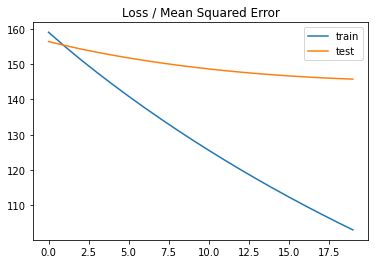

In [23]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(hist_df['loss'], label='train')
pyplot.plot(hist_df['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
predict = lstm_model.predict(test, verbose=0)
predict

array([[[-76.673706,  17.807   ],
        [-94.73462 ,  21.963795],
        [-97.50303 ,  22.600946],
        ...,
        [-97.9443  ,  22.702503],
        [-97.9443  ,  22.702505],
        [-97.9443  ,  22.702505]],

       [[-76.673256,  17.806915],
        [-94.73456 ,  21.963776],
        [-97.50302 ,  22.600943],
        ...,
        [-97.9443  ,  22.702505],
        [-97.9443  ,  22.702505],
        [-97.9443  ,  22.702503]],

       [[-76.673836,  17.807005],
        [-94.734634,  21.963793],
        [-97.50304 ,  22.600946],
        ...,
        [-97.9443  ,  22.702505],
        [-97.9443  ,  22.702503],
        [-97.9443  ,  22.702503]],

       ...,

       [[-76.67248 ,  17.806726],
        [-94.73442 ,  21.96374 ],
        [-97.50299 ,  22.600935],
        ...,
        [-97.9443  ,  22.702501],
        [-97.9443  ,  22.702505],
        [-97.9443  ,  22.702505]],

       [[-76.673676,  17.80694 ],
        [-94.73456 ,  21.963768],
        [-97.50303 ,  22.600945],
        .

In [26]:
for element in test.as_numpy_iterator():
  print(element[1])

[[[ -91.252    9.525]]

 [[ -91.148    9.519]]

 [[ -91.217    9.483]]

 [[ -91.262    9.564]]

 [[ -91.095    9.455]]

 [[ -91.301    9.631]]

 [[ -91.291    9.541]]

 [[ -91.237    9.429]]

 [[ -90.974    9.368]]

 [[ -90.797    9.218]]

 [[ -90.478    9.177]]

 [[ -90.48     9.161]]

 [[ -90.47     9.014]]

 [[ -90.045    8.954]]

 [[ -90.308    9.092]]

 [[ -90.027    8.951]]

 [[ -90.206    9.189]]

 [[ -90.212    9.054]]

 [[ -90.121    9.729]]

 [[ -90.226    9.727]]

 [[ -90.57     9.532]]

 [[ -90.385    9.429]]

 [[ -90.381    9.473]]

 [[ -90.777    8.904]]

 [[ -90.478    9.675]]

 [[ -90.471    9.707]]

 [[ -90.639    9.598]]

 [[ -90.284    9.656]]

 [[ -91.981    9.32 ]]

 [[ -90.031    9.678]]

 [[ -90.1      9.783]]

 [[-104.172   13.282]]]
[[[-89.941   9.283]]

 [[-90.049   9.347]]

 [[-90.156   9.265]]

 [[-90.219   9.315]]

 [[-90.166   9.278]]

 [[-90.311   9.2  ]]

 [[-90.276   9.181]]

 [[-90.338   9.035]]

 [[-90.417   9.043]]

 [[-91.29    9.181]]

 [[-90.384  